In [1]:
# Load libraries
import pandas as pd
import janitor #Clean APIs for data cleaning. Python implementation of R package Janitor
import datetime

from IPython.core.display import display, HTML
from pyvis import network as net #Visualizing network graph
import networkx as nx #Create network graph with Python

In [2]:
# Load Data
df_ori = pd.read_csv('connections.csv', skiprows=2)


In [3]:
df_ori.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1371 entries, 0 to 1370
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   First Name     1357 non-null   object
 1   Last Name      1357 non-null   object
 2   Email Address  12 non-null     object
 3   Company        1336 non-null   object
 4   Position       1339 non-null   object
 5   Connected On   1371 non-null   object
dtypes: object(6)
memory usage: 64.4+ KB


In [4]:
# Data cleaning
df = (
    df_ori
    .clean_names() # remove spacing and capitalization
    .drop(columns=['first_name', 'last_name', 'email_address']) # drop for privacy
    .dropna(subset=['company', 'position']) # drop missing values in company and position
    .to_datetime('connected_on', format='%d %b %Y')
  )
df.head()

,company,position,connected_on
0,US Army,Military,2022-02-22
1,US Navy,Naval Reservist,2022-02-21
2,"RS Leasing, LLC",Payroll Specialist,2022-02-17
3,Codeup,Data Science Instructor and Curriculum Developer,2022-02-14
4,CGI,Business Analyst,2022-02-14


### EDA

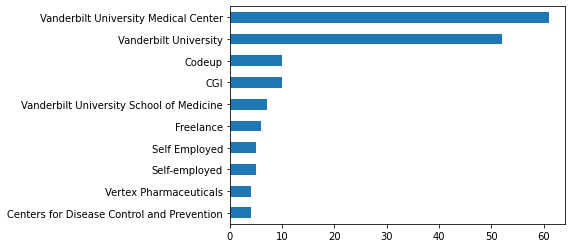

In [5]:
# Top 10 companies
df['company'].value_counts().head(10).plot(kind="barh").invert_yaxis();


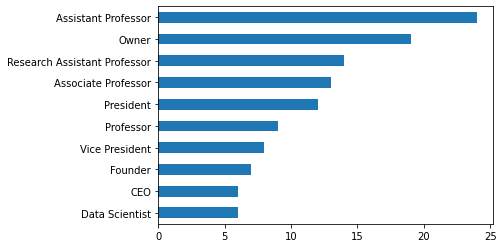

In [6]:
# Top 10 Positions
df['position'].value_counts().head(10).plot(kind="barh").invert_yaxis();


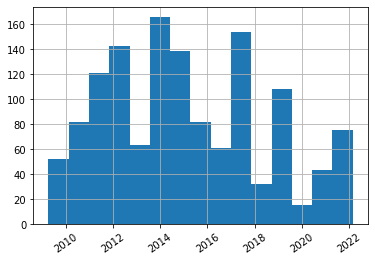

In [7]:
# Month Connected
df['connected_on'].hist(xrot=35, bins=15);


### Aggregate sum of connections for companies


In [8]:
df_company = df['company'].value_counts().reset_index()
df_company.columns = ['company', 'count']
df_company = df_company.sort_values(by="count", ascending=False)
df_company.head(10)

,company,count
0,Vanderbilt University Medical Center,61
1,Vanderbilt University,52
2,Codeup,10
3,CGI,10
4,Vanderbilt University School of Medicine,7
5,Freelance,6
6,Self Employed,5
7,Self-employed,5
12,Mayo Clinic,4
14,US Navy,4


### Aggregate sum of connections for positions


In [9]:
df_position = df['position'].value_counts().reset_index()
df_position.columns = ['position', 'count']
df_position = df_position.sort_values(by="count", ascending=False)
df_position.head(10)

,position,count
0,Assistant Professor,24
1,Owner,19
2,Research Assistant Professor,14
3,Associate Professor,13
4,President,12
5,Professor,9
6,Vice President,8
7,Founder,7
10,Research Scientist,6
9,Data Scientist,6


---

## Creating the Network

In [10]:
nt = net.Network(notebook=True)

g = nx.Graph()
g.add_node(0, label = "root") # intialize yourself as central node
g.add_node(1, label = "Company 1", size=10, title="info1")
g.add_node(2, label = "Company 2", size=40, title="info2")
g.add_node(3, label = "Company 3", size=60, title="info3")
g.add_edge(0, 1)
g.add_edge(0, 2)
g.add_edge(0, 3)

nt.from_nx(g)
nt.show('nodes.html')
display(HTML('nodes.html'))

In [11]:
print(f"number of nodes: {g.number_of_nodes()}")
print(f"number of edges: {g.number_of_edges()}")

number of nodes: 4
number of edges: 3


In [12]:
for _, row in df_company.head(5).iterrows():
  print(row['company'] + "-" + str(row['count']))

Vanderbilt University Medical Center-61
Vanderbilt University-52
Codeup-10
CGI-10
Vanderbilt University School of Medicine-7


In [13]:
print(df_company.shape)
df_company_reduced = df_company.loc[df_company['count']>=5]
print(df_company_reduced.shape)

(1083, 2)
(8, 2)


In [14]:
print(df_position.shape)
df_position_reduced = df_position.loc[df_position['count']>=5]
print(df_position_reduced.shape)

(1098, 2)
(14, 2)


### Visualize Network

In [15]:
# initialize graph
g = nx.Graph()
g.add_node('root') # intialize yourself as central

# use iterrows tp iterate through the data frame
for _, row in df_company_reduced.iterrows():

  # store company name and count
  company = row['company']
  count = row['count']

  title = f"<b>{company}</b> – {count}"
  positions = set([x for x in df[company == df['company']]['position']])
  positions = ''.join('<li>{}</li>'.format(x) for x in positions)

  position_list = f"<ul>{positions}</ul>"
  hover_info = title + position_list

  g.add_node(company, size=count*2, title=hover_info, color='#3449eb')
  g.add_edge('root', company, color='grey')

# generate the graph
nt = net.Network(height='700px', width='700px', bgcolor="black", font_color='white')
nt.from_nx(g)
nt.hrepulsion()
# more customization https://tinyurl.com/yf5lvvdm
nt.show('company_graph.html')
display(HTML('company_graph.html'))

In [16]:
# initialize graph
g = nx.Graph()
g.add_node('root') # intialize yourself as central

# use iterrows tp iterate through the data frame
for _, row in df_position_reduced.iterrows():

  count = f"{row['count']}"
  position= row['position']
  
  g.add_node(position, size=count, color='#3449eb', title=count)
  g.add_edge('root', position, color='grey')

# generate the graph
nt = net.Network(height='700px', width='700px', bgcolor="black", font_color='white')
nt.from_nx(g)
nt.hrepulsion()
# more customization https://tinyurl.com/yf5lvvdm
nt.show('position_graph.html')
display(HTML('position_graph.html'))